In [1]:
%run "../HyperParameterOpt/GenerateExperiments/res_experiment.py"
import copy
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

DIFF_EQ_PARAMS = {
                  "x0": [-20, 10, -.5],
                  "begin": 0,
                  "end": 85,
                  "timesteps": 85000,
                  "train_per": .889,
                  "solver": lorenz_equ,
                  "clip": 40
                 }

RES_PARAMS = {
              "uniform_weights": True,
              "solver": "ridge",
              "ridge_alpha": 1e-6,
              "signal_dim": 3,
              "network": "random graph",

              "res_sz": 15,
              "activ_f": np.tanh,
              "connect_p": .1,
              "spect_rad": 5,
              "gamma": 5,
              "sigma": .14,
              "sparse_res": True,
             }

TOL = 5

In [8]:
np.diff(np.linspace(3, 30, 100))


array([0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272

In [5]:
np.linspace(3, 30, 100)

array([ 3.        ,  3.27272727,  3.54545455,  3.81818182,  4.09090909,
        4.36363636,  4.63636364,  4.90909091,  5.18181818,  5.45454545,
        5.72727273,  6.        ,  6.27272727,  6.54545455,  6.81818182,
        7.09090909,  7.36363636,  7.63636364,  7.90909091,  8.18181818,
        8.45454545,  8.72727273,  9.        ,  9.27272727,  9.54545455,
        9.81818182, 10.09090909, 10.36363636, 10.63636364, 10.90909091,
       11.18181818, 11.45454545, 11.72727273, 12.        , 12.27272727,
       12.54545455, 12.81818182, 13.09090909, 13.36363636, 13.63636364,
       13.90909091, 14.18181818, 14.45454545, 14.72727273, 15.        ,
       15.27272727, 15.54545455, 15.81818182, 16.09090909, 16.36363636,
       16.63636364, 16.90909091, 17.18181818, 17.45454545, 17.72727273,
       18.        , 18.27272727, 18.54545455, 18.81818182, 19.09090909,
       19.36363636, 19.63636364, 19.90909091, 20.18181818, 20.45454545,
       20.72727273, 21.        , 21.27272727, 21.54545455, 21.81

In [36]:
def adj_matrix(topology, topo_params, n, remove_p=0):
    adj = generate_adj(topology, topo_params, n)
    adj = remove_edges(adj, floor(remove_p*np.sum(adj != 0)))
    return adj

def res_acc(rc, u, test_t):
    pre = rc.predict(test_t)
    return how_long_accurate(u(test_t), pre, tol=TOL)

def train_rc(adj, diff_eq_params, res_params):
    diff_eq_params["x0"] = random_lorenz_x0()
    train_t, test_t, u = rc_solve_ode(diff_eq_params)
    rc = ResComp(adj, **res_params)
    rc.fit(train_t, u)
    r0 = rc.state_0
    return rc, r0, res_acc(rc, u, test_t)

def effective_adj(rc):
    return rc.res + rc.sigma * rc.W_in @ rc.W_out

def W_out_kde(rc):
    kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
    kde.fit(rc.W_out.ravel().reshape(-1,1))
    return kde

def random_W_out(rc):
    old_W_out = np.copy(rc.W_out)
    kde = W_out_kde(rc)
    rand_W_out = kde.sample(rc.W_out.shape)
    rc.W_out = rand_W_out.reshape(rc.W_out.shape)
    return rc, old_W_out

In [39]:
rc = ResComp(**RES_PARAMS)
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)

def zerof(x):
    if type(x) is float:
        return np.zeros(rc.signal_dim)
    else:
        return np.zeros((rc.signal_dim, len(x)))
    
err, states = rc.fit(train_t, zerof, return_states=True)

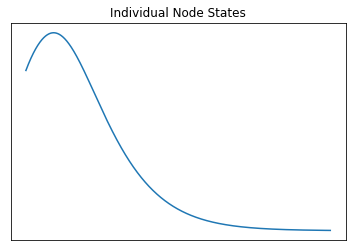

In [45]:
plt.plot(states[:2000,])
plt.xticks([])
plt.yticks([])
plt.title("Individual Node States")
plt.show()

In [335]:
good_predict = []
bad_predict = []
res_ps = copy.deepcopy(RES_PARAMS)
diff_ps = copy.deepcopy(DIFF_EQ_PARAMS)
n = 2500
topo = "geom"

for i in range(25):
    adj = adj_matrix(topo, 2.5, 2500, remove_p=.9)
    rc, r0, acc = train_rc(adj, diff_ps, res_ps)
    print(acc)
    if acc > 4000:
        good_predict.append((rc, r0))
    if acc < 500:
        bad_predict.append((rc, r0))

133
4995
2513
1741
2694
1615
3452
1489
1709
756
1829
4995
1936
3175
1928
2426
2318
1227
1475
573
917
3469
1254
1973
4995


In [ ]:
drdt = tanh(A * r)

In [365]:
random_rc.W_out = orig_W_out

In [366]:
random_rc, r0 = bad_predict[0]

In [367]:
orig_W_out = random_rc.W_out
orig_r0 = r0

In [527]:
random_rc, W_out = random_W_out(random_rc)

In [610]:
W = np.random.rand(*W_out.shape)
W -= .5
W *= 100
random_rc.W_out = W

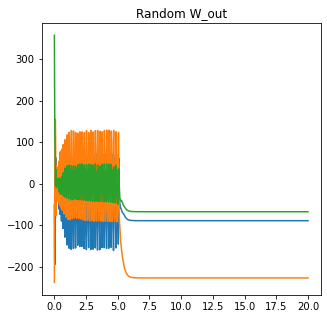

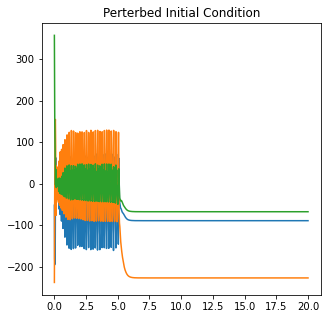

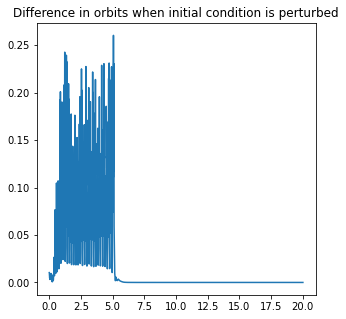

In [611]:
tmax = 20
dt = .01
plt.rcParams["figure.figsize"] = [5,5]
t = np.linspace(0, tmax, int(tmax/dt))
random_rc.state_0 = np.random.rand(random_rc.res_sz) - .5
pre = random_rc.predict(t)
plt.plot(t, pre.T)
plt.title("Random W_out")
plt.show()

random_rc.state_0 += .0001*(np.random.rand() - 0.5)
pre_pert = random_rc.predict(t)
plt.plot(t, pre_pert.T)
plt.title("Perterbed Initial Condition")
plt.show()

err = np.sum((pre_pert - pre)**2, axis=0)**.5
plt.plot(t, err)
plt.title("Difference in orbits when initial condition is perturbed")
plt.show()

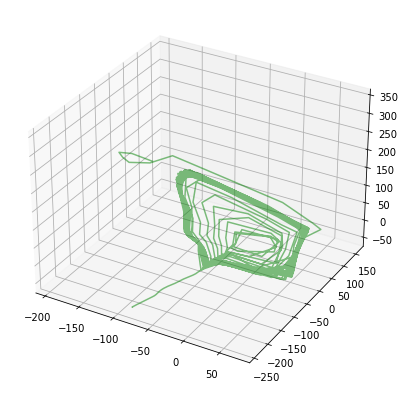

In [612]:
plt.rcParams["figure.figsize"] = [7,7]
ax = plt.axes(projection='3d')

x,y,z = pre[0,:], pre[1,:], pre[2,:]
ax.plot3D(x, y, z, 'g',alpha=.5, label="Predicted Orbit")


ax.set_title = "3D Orbit"
plt.show()

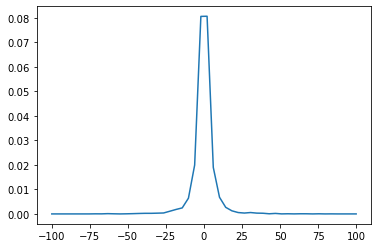

In [40]:
from sklearn.neighbors import KernelDensity

x = np.linspace(-100, 100).reshape(-1,1)
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(rc.W_out.ravel().reshape(-1,1))
plt.plot(x, np.exp(kde.score_samples(x)))

In [42]:
kde.sample((3,2500))

array([[[17.8248383 ],
        [ 6.04149989],
        [ 1.72945883],
        ...,
        [ 6.48961676],
        [ 0.38791264],
        [ 6.55416344]],

       [[-0.82674195],
        [ 4.66743304],
        [10.45332072],
        ...,
        [-0.62828302],
        [ 1.90573762],
        [ 2.09982403]],

       [[ 0.14541768],
        [ 1.40125923],
        [ 9.61064566],
        ...,
        [ 4.553032  ],
        [ 5.23252636],
        [-5.83291795]]])

In [8]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

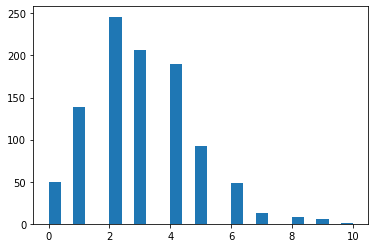

2.979


In [42]:
A = np.random.randn(1000, 1000)
G = (np.abs(A) > 2.98) * 1.0 
x = plt.hist(np.sum(G, axis=0), bins=25, log=False)
plt.show()
print(np.mean(np.sum(G, axis=0)))

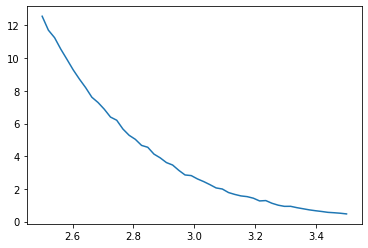

In [43]:
x = np.linspace(2.5,3.5)
c = np.zeros_like(x)
for i, cut in enumerate(x):
    A = np.random.randn(1000, 1000)
    G = (np.abs(A) > cut) * 1.0 
    c[i] = np.mean(np.sum(G, axis=0))
plt.plot(x, c)

In [45]:
cut = 2.98
A = np.random.randn(1000, 1000)
G = (np.abs(A) > cut) * 1.0 
g = nx.DiGraph(G)
compsz = [len(comp) for comp in nx.strongly_connected_components(g)]
print(max(compsz))

866


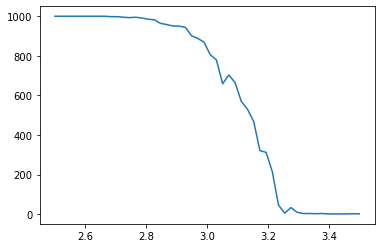

In [47]:
x = np.linspace(2.5,3.5)
gc = np.zeros_like(x)
for i, cut in enumerate(x):
    A = np.random.randn(1000, 1000)
    G = (np.abs(A) > cut) * 1.0 
    g = nx.DiGraph(G)
    compsz = [len(comp) for comp in nx.strongly_connected_components(g)]
    gc[i] = max(compsz)
plt.plot(x, gc)